In [1]:
# yfinance 패키지 설치
!pip install yfinance --quiet

In [2]:
# 패키지 임포트: numpy, pandas, matplotlib, seaborn, yfinance, scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

# seaborn 세팅하기
sns.set()

In [3]:
tickers = ["MSFT", "GOOG", "AMZN", "JPM","TSLA","BAC"]

stocks = yf.Tickers(tickers)

data = stocks.history(start='2013-01-01', actions=False)

# 종가 이외의 데이터 제거
data.drop(['Open', 'High', 'Low', 'Volume'], inplace=True, axis=1)

# 열 이름 레벨 다운그레이드
data = data.droplevel(0, axis=1)

[*********************100%%**********************]  6 of 6 completed


In [4]:
# 티커 설정
ticker = "^IXIC"

# 데이터 가져오기
N_data = yf.download(ticker, start='2013-01-01')

# 종가 데이터만 남기기
N_data = N_data['Close']

# 데이터 확인
print(N_data.head())

[*********************100%%**********************]  1 of 1 completed
Date
2013-01-02    3112.260010
2013-01-03    3100.570068
2013-01-04    3101.659912
2013-01-07    3098.810059
2013-01-08    3091.810059
Name: Close, dtype: float64


In [5]:
# 수익률 데이터
rets = data.pct_change().fillna(0)

# 기대수익률 계산
er = rets.mean() * 252

# 공분산행렬 계산
cov = rets.cov() * 252

In [6]:
#나스닥 수익률
N_rets = N_data.pct_change().fillna(0)
#나스닥 기대수익률
N_er = N_rets.mean() *252

# 알파와 베타 구하기

In [7]:
import statsmodels.api as sm

In [8]:
alpha = []
beta = []

for ticker in rets.keys():

  X = N_rets.values
  y = rets[ticker].values

  X = sm.add_constant(X)

  model = sm.OLS(y, X)

  results = model.fit()
  alpha.append(results.params[0])
  beta.append(results.params[1])
  print(f"{ticker}: ", results.params[0], results.params[1])


AMZN:  0.00036821785826911415 1.1382115348677107
BAC:  4.122210736051628e-05 0.8828470908990943
GOOG:  0.00022070091111920203 1.044228341352413
JPM:  0.00022219901124168073 0.777553878538602
MSFT:  0.00047540184764933085 1.068033481240088
TSLA:  0.0013205699692054023 1.46385308483383


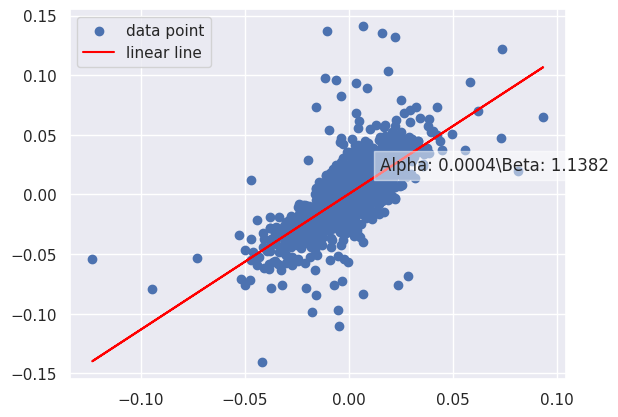

In [9]:
import matplotlib.pyplot as plt

# 회귀선 시각화
plt.scatter(N_rets, rets["AMZN"], label='data point')
plt.plot(N_rets, beta[0] * N_rets + alpha[0], color='red', label='linear line')

# 알파와 베타 값 출력
plt.text(0.015, 0.02, f'Alpha: {alpha[0]:.4f}\Beta: {beta[0]:.4f}', bbox=dict(facecolor='white', alpha=0.5))


# 범례 표시
plt.legend()

# 그래프 표시
plt.show()

# Bayesian Linear Regression

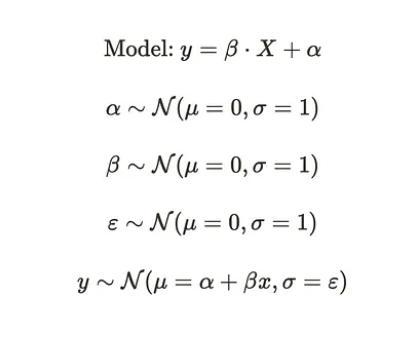

확률적으로 알파와 베타를 구해보자

In [ ]:
!pip install pymc==4.1.4

In [11]:
import pymc as pm
import arviz as az

In [12]:
X = N_rets.values
y = rets["AMZN"].values

with pm.Model() as model_1:

    alpha = pm.Normal("alpha", mu=0, sigma=1)
    beta = pm.Normal("beta", mu=0, sigma=1)

    exp_returns = pm.Deterministic("exp_returns", alpha + beta * X)
    noise = pm.HalfNormal("noise", sigma=1)

    returns = pm.Normal("returns", mu=exp_returns, sigma=noise, observed=y)

    trace_1 = pm.sample(tune=1500)

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


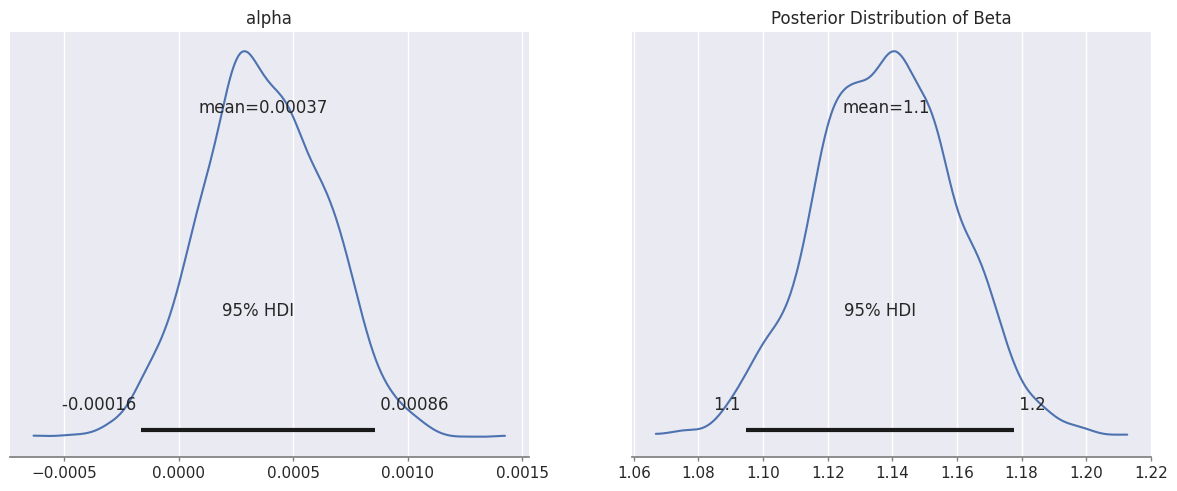

In [13]:
# 결과 출력
az.plot_posterior(trace_1, var_names=['alpha','beta'], hdi_prob=0.95, round_to=2)
plt.title('Posterior Distribution of Beta')
plt.show()

# 샤프 비율 최대화 포트폴리오

In [14]:
# 샤프비율 최대화 포트폴리오 가중치 산출 함수 구현
def get_pf_weights(er, cov):

    # 자산개수
    noa = er.shape[0]

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 자산 가중치 상하한
    bounds = ((0.0, 1.0), ) * noa

    # 레버리지 불가 제약조건
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1}

    # 목적함수
    def neg_sharpe(weights, er, cov):
        r = weights.T @ er
        vol = np.sqrt(weights.T @ cov @ weights)
        return - r / vol

    # 최적화 수행
    res = sco.minimize(neg_sharpe,
                       init_guess,
                       args=(er, cov),
                       method='SLSQP',
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)

    return res.x

In [15]:
# 포트폴리오 가중치
pf_weights = get_pf_weights(er, cov)

# 포트폴리오 수익률
pf_ret = np.dot(pf_weights, er)

# 포트폴리오 변동성
pf_vol = np.sqrt(np.dot(pf_weights.T, np.dot(cov, pf_weights)))

print('Return = {}'.format(pf_ret))
print('Volatility = {}'.format(pf_vol))

Return = 0.34218782071324344
Volatility = 0.265280049450714


<Axes: >

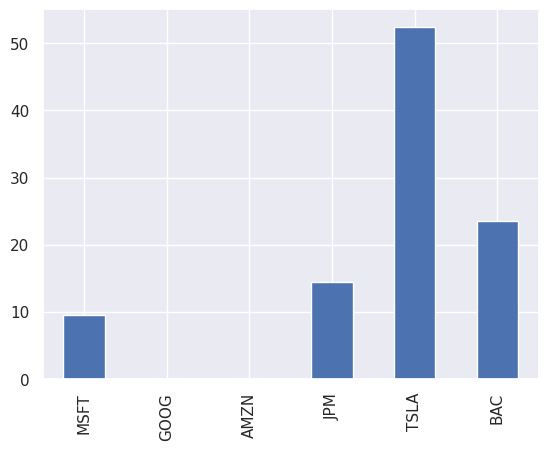

In [16]:
# 시장 포트폴리오 가중치 시각화
pf_weights_series = pd.Series(np.round(pf_weights, 4) * 100, index=tickers)
pf_weights_series.plot.bar()

위 그래프가 위험대비 수익률을 최대화하는 비율을 알려준다

# 자본시장선

In [17]:
# 포트폴리오 통계치 계산 함수
def statistics(weights):
    weights = np.array(weights)
    pret = np.sum(er * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(cov, weights)))
    return np.array([pret, pvol, pret/pvol])

# 목적함수 정의
def obj_func(weights):
    return statistics(weights)[1]

In [49]:
# 자산의 개수
noa = len(tickers)

# 수익률 수준별 포트폴리오 최적화 수행
trets = np.linspace(0.2, 0.5, 50)
tvols = []

for tret in trets:

    # 가중치 초기값
    init_guess = np.repeat(1/noa, noa)

    # 제약조건
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

    # 자산 가중치 상하한
    bnds = ((0.0, 1.0), ) * noa

    # 최적화 수행
    res = sco.minimize(obj_func,
                       init_guess,
                       method='SLSQP',
                       bounds=bnds,
                       constraints=cons)

    tvols.append(res['fun'])

tvols = np.array(tvols)

In [50]:
# 좌측 경계선 데이터 수집
ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

Text(0.5, 1.0, 'Market Portfolio & Capital Market Line')

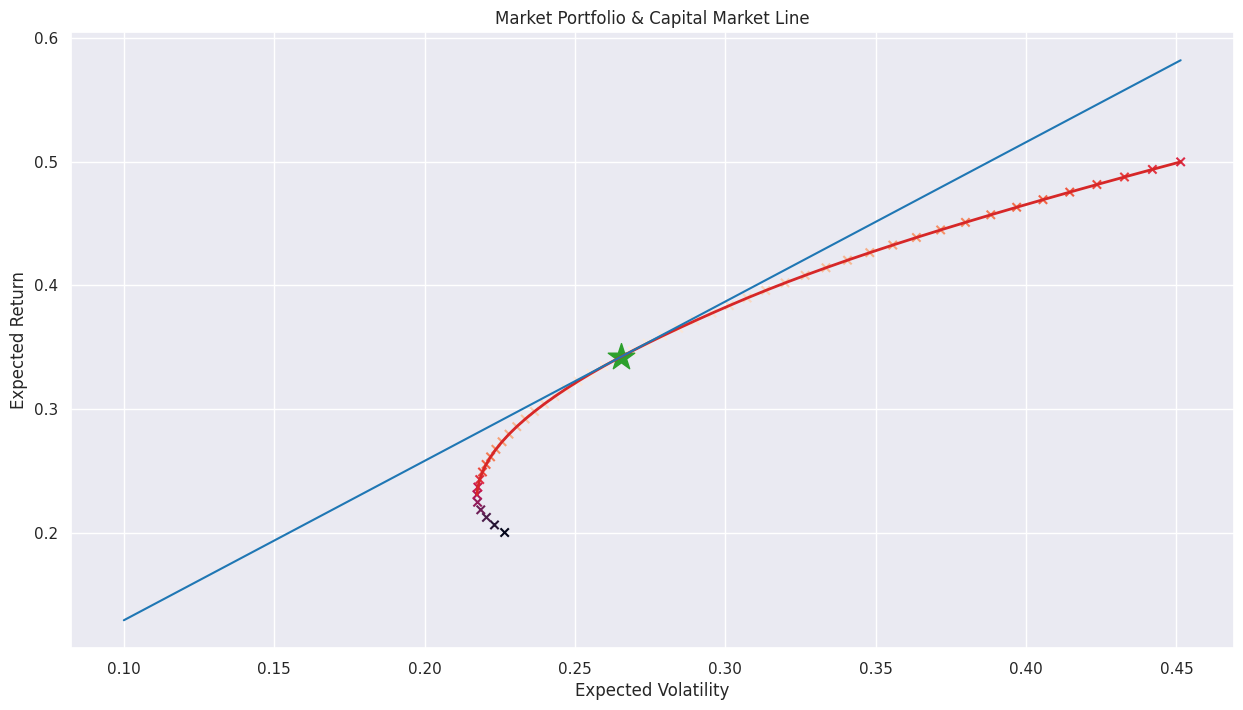

In [51]:
# 자본시장선 데이터
x = np.linspace(0.1, evols[-1], 100)
y = (pf_ret / pf_vol) * x

# 효율적 경계선 및 자본시장선 시각화
plt.figure(figsize=(15, 8))

plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(evols, erets, 'tab:red', lw=2.0)

# 시장 포트폴리오
plt.scatter(pf_vol, pf_ret, marker='*', s=400, color='tab:green')

# 자본시장선
plt.plot(x, y, 'tab:blue')

plt.grid(True)

plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

plt.title('Market Portfolio & Capital Market Line')